In [1]:
# sinc(x) = sin(πx)/(πx)
# sinc(x) = np.sin(np.pi * x)/(np.pi * x)
# objective = y(x) = sinc(x + 10) + sinc(x) + sinc(x − 10)

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from numpy.linalg import inv
from sklearn.metrics.pairwise import euclidean_distances

%matplotlib inline

In [38]:
def sinc(x):
    return np.sin(np.pi * x) / (np.pi * x)

def objective(x):
    return sinc(x+10) + sinc(x) + sinc(x-10)

In [39]:
pts = 50
X = np.linspace(-15,15,pts) # value locations
y = objective(X) # objective function

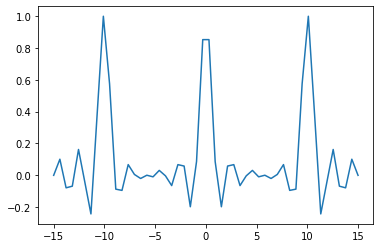

In [40]:
plt.plot(X,y)

In [49]:
D = np.concatenate([X[X<=-4.5], X[X>=4.5]]) # value locations we know
unk = X[np.logical_and(X>-4.5, X<4.5)]

In [50]:
def dist(X1, X2):
    G1 = (X1**2).reshape(-1,1)
    G2 = (X2**2).reshape(-1,1)
    return np.sqrt(G1 + G2.T - 2 * np.dot(X1,X2.T))

def sqdist(X1, X2):
    G1 = (X1**2).reshape(-1,1)
    G2 = (X2**2).reshape(-1,1)
    return G1 + G2.T - 2 * np.dot(X1,X2.T)

def kernSM_helper(x1, x2, weights, means, covs):
    # K(x,x')= sum_i^Q w_i * exp(-2pi^2*(x-x').T*covs_i*(x-x'))cos(2pi*(x-x').T*means(i))
    d = x1-x2
    Q = weights.shape[0]
    K = 0
    for i in range(Q):
        Ki = weights[i] * np.exp(-2 * np.pi * covs[i] * np.square(d)) * np.cos(2 * np.pi * d * means[i])
        K += Ki
    try:
        return K[0]
    except:
        return K

def kernSM(X1, X2, weights, means, covs):
    return np.array([[kernSM_helper(x1,x2,weights,means,covs) for x1 in X2.ravel()] for x2 in X1.ravel()])
        
    
def predict(X, X_train, Y_train, kernFunc, weights, means, covs):
    C = kernFunc(X_train, X_train, weights, means, covs)
    kappa = kernFunc(X_train, X, weights, means, covs)
    K = kernFunc(X,X, weights, means, covs) + 1e-8 * np.eye(len(X))
    
    u = kappa.T.dot(inv(C)).dot(Y_train)
    cov = K - kappa.T.dot(inv(C)).dot(kappa)
    return u, cov
        
# hyps = [weight vector, mean vector, covariance vector]
def marginalLikelihood(hyps, objval, xInds, Q, sig):
    w = hyps[:Q].reshape(-1,1)
    m = hyps[Q:2*Q].reshape(-1,1)
    cov = hyps[2*Q:].reshape(-1,1)
    
    
    zeroMean = np.zeros_like(objval)
    
    condMean, condKern = predict(xInds, xInds, objective(xInds), kernSM, w, m, cov)
    return -.5 * (objval - condMean).T @ inv(condKern + sig) @ (objval - condMean) - .5 * np.linalg.det(condKern + sig) - len(xInds)/2 * np.log(2*np.pi)

In [51]:
Q = 5
Dvect = D.reshape(-1,1)
Wvect = np.random.choice(np.arange(100)+1, Q, replace=False) / 10
Mvect = np.random.random(Q)
Cvect = np.random.random(Q)
noise = .005 * np.eye(Dvect.shape[0])

In [52]:
hyps = np.concatenate([Wvect, Mvect, Cvect])

In [53]:
optHyps = optimize.fmin_cg(marginalLikelihood, hyps, args=(objective(D).reshape(-1,1), Dvect, Q, noise))

Optimization terminated successfully.
         Current function value: -33.081787
         Iterations: 0
         Function evaluations: 17
         Gradient evaluations: 1


In [54]:
optw = optHyps[:Q].reshape(-1,1)
optm = optHyps[Q:2*Q].reshape(-1,1)
optcov = optHyps[2*Q:].reshape(-1,1)

In [55]:
u_posterior, K_posterior = predict(unk, Dvect, objective(D).reshape(-1,1), kernSM, optw, optm, optcov)
post_samples = np.random.multivariate_normal(u_posterior.ravel(), K_posterior, 1)

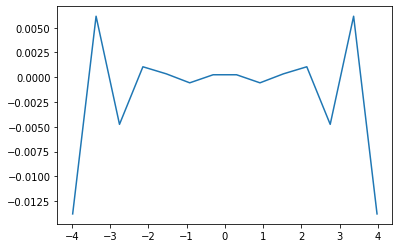

In [56]:
plt.plot(unk, u_posterior.ravel())

# Reflection:

I think I may have gone a bit too hard on this one, as it took me a couple days to get to a working state, but I found this problem to be extremely interesting when I first read about it in this paper: https://arxiv.org/pdf/1302.4245.pdf

Although the problem is a bit difficult, I feel that it covers the scope of chapter 3 fairly well, and requires a strong grasp of the concepts we have learned so far.